Adam Miles
CS6017
Homework4
## Part 1: Data Acquisition

Each spatial partitioning data structure was benchmarked using the following parameter ranges, after their outputs were validated through differential testing with the naive search implementation. 

The benchmark cmake was configured as follows:

cmake_minimum_required(VERSION 3.10)
project(Homework4)

set(CMAKE_CXX_STANDARD 17)
set(Sources UnitTests.cpp)
set(Headers Generators.hpp BucketKNN.hpp KDTree.hpp Point.hpp Stopwatch.hpp catch.hpp UnitTests.cpp Naive.hpp Benchmark.hpp Spinner.hpp QuadTree.hpp VPTree.hpp)
add_executable(superlib ${Sources} ${Headers})

add_executable(Homework4 main.cpp)

Each experiment was tested using both a uniform and gaussian distribution for the points collection. The points were generated using random floats from the range (-1000 - 1000).

k was increased linearly from 1 to 10, with an offset of 1.

The number of points in the collection were increased geometrically, doubling up to a maximum of 10000 points. 

In [1]:
import glob, os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns; sns.set(style="ticks", color_codes=True)
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings("ignore")

In [2]:
filepath='/Users/adam/Box Sync/milesar/CS 6017/Homework4/cmake-build-debug' 

all_files = glob.glob(os.path.join(filepath, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
df   = pd.concat(df_from_each_file, ignore_index=True)

df['distribution'] = df['distribution'].astype('str')
df['structure'] = df['structure'].astype('str')
df.dtypes

points            int64
distribution     object
k                 int64
avg_knn_time    float64
structure        object
dimensions        int64
dtype: object

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style({'xtick.minor.size': 3}, {'ytick.minor.size': 3})
sns.axes_style()


{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.linewidth': 1.25,
 'axes.labelcolor': '.15',
 'figure.facecolor': (1, 1, 1, 0),
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 3.0,
 'ytick.minor.size': 3.0,
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif']}

## Part 2: Individual Spatial Partitioning Data-Structure Analysis

The data structures were each analyzed individually, since several had unique configuration parameters that affected the performance. Before running the final comparison tests, these were optimized as much as possible so that each strucure presented a best effort solution for the trial parameters.

## KDTree

The k-dimensional tree did not have any structural parameters to modify, but it was to benchmark it against the naive solution a measure its performance with varying k, dimensions, and the size of the point collection.

##### Point distribution
To observe any trends in performance vs the distribution of the data in increasing dimension spaces, k and the number of points were fixed.

Interstingly, the KDTree saw an NLogN increase in the time complexity required to perform the same search with respect to the number of dimensions searched with a uniform distribution, but was able to maintain closer to a constant or LogN complexity with a guassian distribution. I don't have a good explanation as to why this is the case, but will try to pencil one in here later.

In [4]:
kdtree = df['structure'] == "KDTree"
k = df['k'] == 10
points = df['points'] == 6400
dim3 = df['dimensions'] == 3

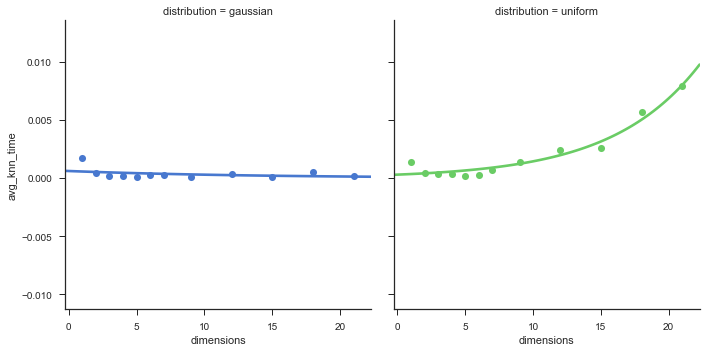

In [5]:
g = sns.lmplot(x="dimensions", y="avg_knn_time", col="distribution", hue="distribution", data=df[kdtree & k & points],
           ci=None, palette="muted", size=5, logistic=True,
           scatter_kws={"s": 50, "alpha": 1})

##### Point distribution

The next feature probed was the performance as a factor of the number of knn's searched for. The dimension space was fixed at 3, and the number of points in the collection was fixed at 6400.


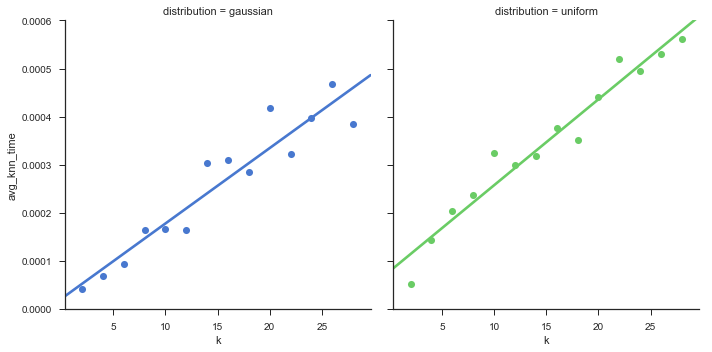

In [6]:
g = sns.lmplot(x="k", y="avg_knn_time", col="distribution", hue="distribution", data=df[kdtree & dim3 & points],
           col_wrap=2, ci=None, palette="muted", size=5, 
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.0006))

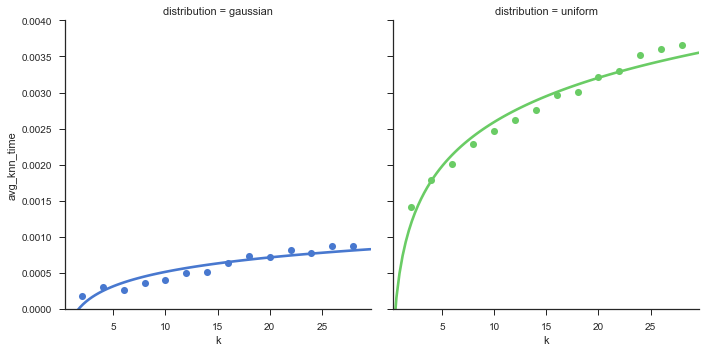

In [7]:
dim12 = df['dimensions'] == 12
g = sns.lmplot(x="k", y="avg_knn_time", col="distribution", hue="distribution", data=df[kdtree & dim12 & points],
           col_wrap=2, ci=None, palette="muted", size=5, logx=True,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.004))

For the same number of points and independent of the dimension space, the search performance increased with LogN time complexity with respect to the number of nearest neighboors required in the search. The KDTree exhibited 5 fold slower knn search times for the uniform distribution vs the gaussian sampling in the 12 dimensional space, and continued to perform poorly as the number of dimensions increased. 

##### Point collection size

The final set of parameters probed was the performance vs the point collection size (up to 6400 points) for a few fixed dimensions and nn size.

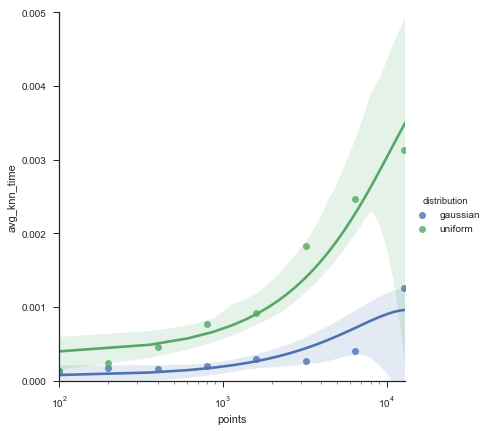

In [8]:
g.set(ylim=(0, 0.003))
g = sns.lmplot(x="points", y="avg_knn_time", hue="distribution", order=2,
               truncate=True, size=6, data=df[kdtree & dim12 & k])
g.set(ylim=(0, 0.005))
g.ax.set_xscale('log')
g.set(xlim=(100, 13000))

With the median number of dimensions (12) the gaussian distribution performed with 10 times the efficiency of the uniform distribution, again suggesting that for highly clustered data above 1000 points, the KDTree will perform much better than a more uniform distribution. With the maximum dimensions tested, the gaussian distribution maintains very consistent perforamnce while the uniform distribution tanks dramatically, seeing a 100 fold decrease in efficiency for the same searh parameters.

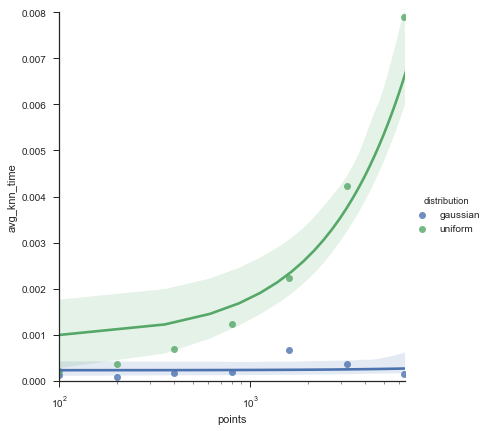

In [9]:
dim21 = df['dimensions'] == 21
g = sns.lmplot(x="points", y="avg_knn_time", hue="distribution",
               truncate=True, size=6, data=df[kdtree & dim21 & k])
g.set(ylim=(0, 0.008))
g.ax.set_xscale('log')
g.set(xlim=(100, 6500))

## QuadTree

The quadtree is designed for spatial partioning in 2 dimensions, so that variable was suitably fixed. The number of points stored in the leaves (which would result in small linear searches and smaller storage footprint at the cost of search efficiency) was left variable and included as a parameter in the tree constructor. For this portion of the analysis, the number of points per leaf node was fixed at 1. 

##### Point distribution
To observe any trends in performance vs the distribution of the data where k and the number of points were fixed.

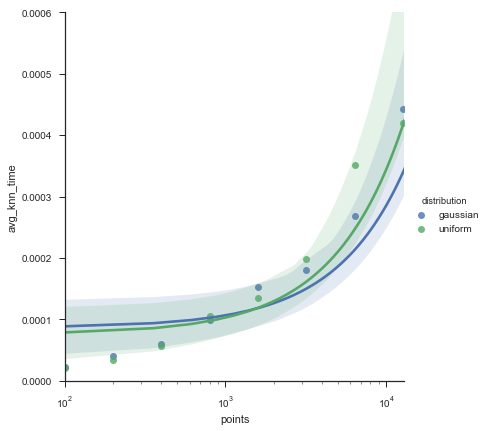

In [10]:
quadtree = df['structure'] == "QuadTree"
k = df['k'] == 10
points = df['points'] == 6400

g = sns.lmplot(x="points", y="avg_knn_time", hue="distribution",
               truncate=True, size=6, data=df[quadtree & k])
g.set(ylim=(0, 0.0006))
g.ax.set_xscale('log')
g.set(xlim=(100, 13000))

The quadtree demonstrated little performance difference between the uniform and gaussian distributions (dimensionality is suffienctly low that it probably mitigated the effects of the distance querries increasing complexity).

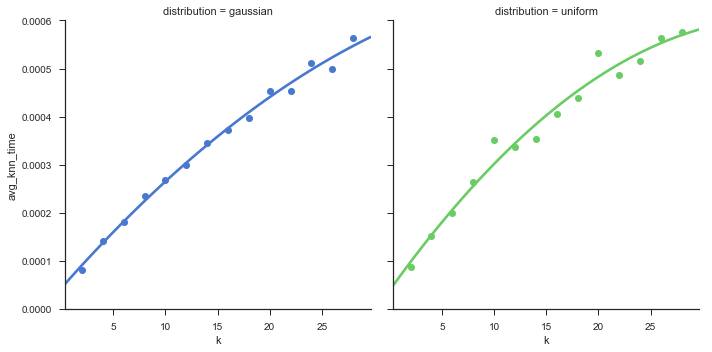

In [11]:
g = sns.lmplot(x="k", y="avg_knn_time", col="distribution", hue="distribution", data=df[quadtree & points],
           col_wrap=2, ci=None, palette="muted", size=5, order=2,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.0006))

## VPTree

The vantage point tree was implemented with two key differences: in one tree, the vantage point at each node was selected randomly, and in the other the median point within the hypersphere was selected as the next vantage point. The median VP tree was implemented here, and the random VP tree will be tested time allowing.

##### Point distribution
To observe any trends in performance vs the distribution of the data in increasing dimension spaces, k and the number of points were fixed.

In [12]:
vptree = df['structure'] == "VPTree"
k = df['k'] == 10
points = df['points'] == 6400
dim3 = df['dimensions'] == 3

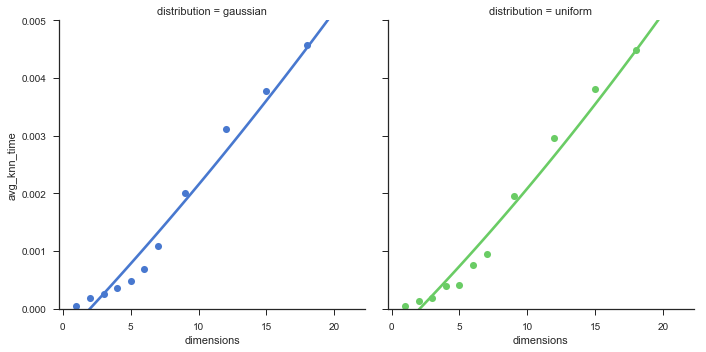

In [13]:
g = sns.lmplot(x="dimensions", y="avg_knn_time", col="distribution", hue="distribution", data=df[vptree & k & points],
           ci=None, palette="muted", size=5, order=2,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.005))

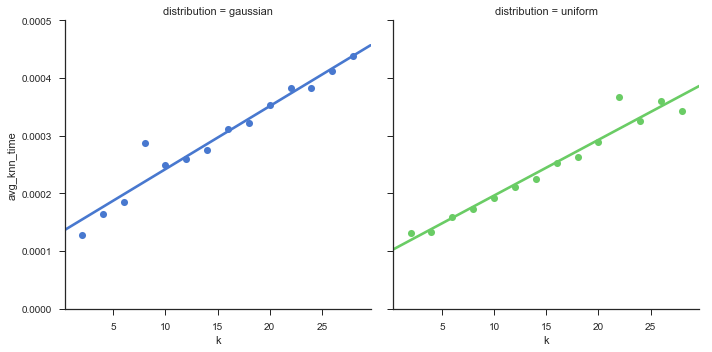

In [14]:
g = sns.lmplot(x="k", y="avg_knn_time", col="distribution", hue="distribution", data=df[vptree & dim3 & points],
           col_wrap=2, ci=None, palette="muted", size=5, 
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.0005))

For the same number of points and independent of the dimension space, the VPTree performed equally for both the gaussian and uniform distributions.

##### Point collection size

The final set of parameters probed was the performance vs the point collection size (up to 6400 points) for a few fixed dimensions and nn size.

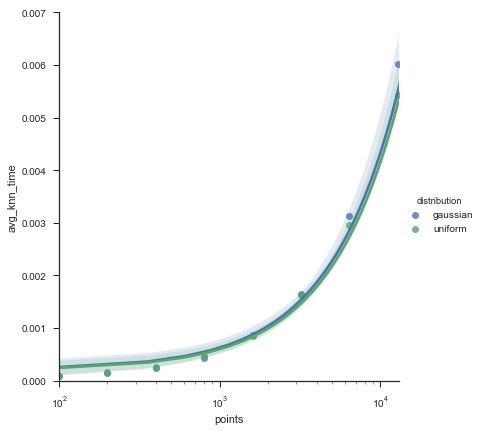

In [15]:
g.set(ylim=(0, 0.003))
g = sns.lmplot(x="points", y="avg_knn_time", hue="distribution",
               truncate=True, size=6, data=df[vptree & dim12 & k])
g.set(ylim=(0, 0.007))
g.ax.set_xscale('log')
g.set(xlim=(100, 13000))

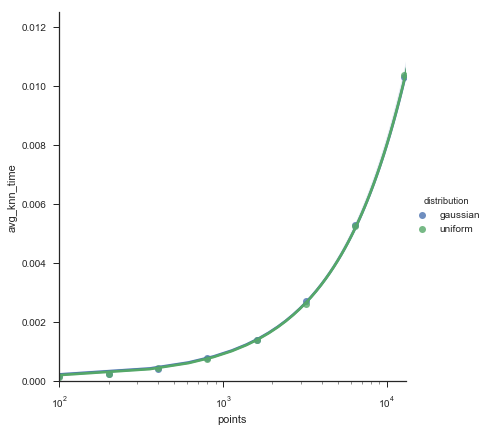

In [16]:
dim21 = df['dimensions'] == 21
g = sns.lmplot(x="points", y="avg_knn_time", hue="distribution",
               truncate=True, size=6, data=df[vptree & dim21 & k])
g.set(ylim=(0, 0.0125))
g.set_titles("average knn time vs point collection size for 21 dimensional space and k = 10")
g.ax.set_xscale('log')
g.set(xlim=(100, 13000))

The VPTree was not evidently the most performant solution in d-dimensions for nearest neighboor querries. However, it was certainly a reliable structure for cases where the distribution is unknown ahead of time.

## Part 3: Comparison of structures

The structures are compared and contrasted for performing k nearest neighbor queries, in order to identify the best use cases of each.


### 2 Dimensions

This is the only space in which all 4 structures could be compared, since the quadtree is designed exclusively for this dimension space.

In [17]:
k = df['k'] == 12
points = df['points'] == 6400
dim2 = df['dimensions'] == 2

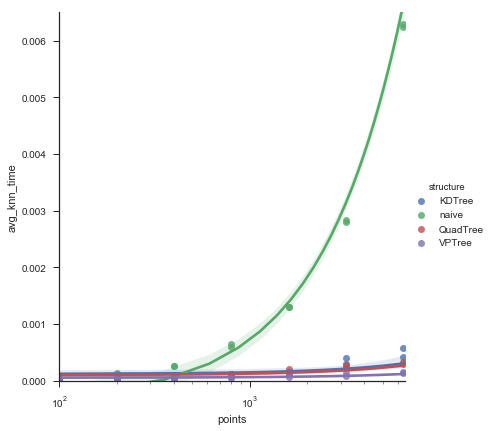

In [18]:
g = sns.lmplot(x="points", y="avg_knn_time", hue="structure",
               truncate=True, size=6, data=df[dim2 & k])
g.set(ylim=(0, 0.0065))
g.ax.set_xscale('log')
g.set(xlim=(100, 6500))

We can see that the naive solution rockets off with exponential complexity, due to the unmitigated effects of the curse of dimensionality, and that the other 3 structures are much the better tools for the job. Taking out the naive solution which we knew would be pretty poor, we can see that the VPTree actually performs the best for the current data sets with respect to the number of points and k = 10.

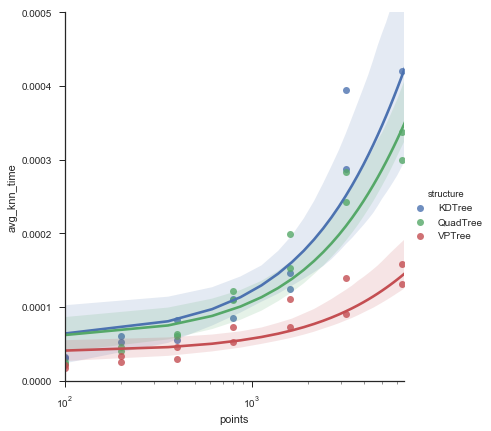

In [19]:
g = sns.lmplot(x="points", y="avg_knn_time", hue="structure", order = 2,
               truncate=True, size=6, data=df[dim2 & k & (kdtree | vptree | quadtree)])

g.set(ylim=(0, 0.0005))
g.ax.set_xscale('log')
g.set(xlim=(100, 6500))
g.set_titles("knn temporal performance for ")

For knn querries in 2 dimensional space, the quadtree (1 point per leaf) performs ~2X better than the KDTree, but ~1/2 as well as the VPTree (for the range 200 - 2000 tested, but we can see that the difference will continue to diverge), independent of the distribution. Another view of the same data, by distribution:

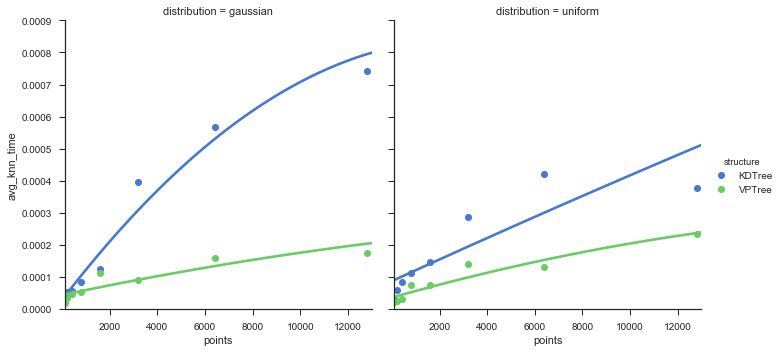

In [20]:
uniform = df["distribution"] == "uniform"
gaussian = df["distribution"] == "gaussian"
g = sns.lmplot(x="points", y="avg_knn_time", col="distribution", hue="structure", data=df[(kdtree | vptree) & k & dim2],
           ci=None, palette="muted", size=5, order=2,
           scatter_kws={"s": 50, "alpha": 1})

g.set(ylim=(0, 0.0009))
g.set(xlim=(100, 13000))

### D Dimensions

The comparison of the KDTree and VPTree's was quite interesting, especially with regard to the distribution and performance over increasing dimensions.

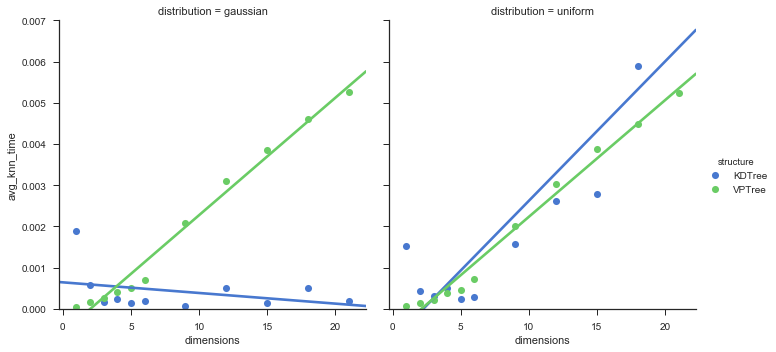

In [21]:
g = sns.lmplot(x="dimensions", y="avg_knn_time", col="distribution", hue="structure", data=df[(kdtree | vptree) & k & points],
           ci=None, palette="muted", size=5,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.007))

Strangely, the performance settles down for the KDTree quite dramtically, and it performs much better than the VPTree for gaussian distributions. As the dimension space increases, with a uniform distribution, the VPTree does begin to perform much better than the KDTree (d > 15). So, for dimensions up to 15, the KDTree is a clear winner, especially if the data is likely to be highly clusterred within a narrow range. But for d > 15 and general performance regularity, the VPTree might be a better choice for KNN querries.

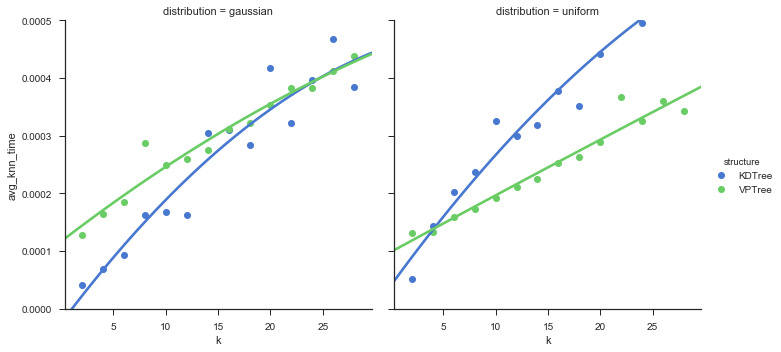

In [22]:
g = sns.lmplot(x="k", y="avg_knn_time", col="distribution", hue="structure", data=df[(kdtree | vptree) & dim3 & points],
           col_wrap=2, ci=None, palette="muted", size=5, order=2,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, 0.0005))

For increasing k, we also see another advantage for the VPTree, where its avg_knn_time increases much more slowly than the KDTree with a uniform distribution, and somewhat slower with a gaussian distribution.

In either case, for larger knn querries (k > 10), this gives the VPTree a nice advantage. 

In [23]:
model = ols("avg_knn_time ~ structure + k + points + dimensions", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_knn_time   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     780.1
Date:                Mon, 02 Jul 2018   Prob (F-statistic):               0.00
Time:                        11:17:05   Log-Likelihood:                 28833.
No. Observations:                6468   AIC:                        -5.765e+04
Df Residuals:                    6461   BIC:                        -5.760e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0022   9.77e-05    -22.608      0.000      -0.002      -0.002
structure[T.QuadTree]     0.0005      0.000      2.532      0.011       0.000       0.001
structure[T.VPTree]       0.0006   7.35e-05      7.874      0.000       0.000       0.001
structure[T.naive]        0.0057      0.000     37.210      0.000       0.005       0.006
k                      2.213e-05   4.29e-06      5.162      0.000    1.37e-05    3.05e-05
points                 2.283e-07   4.44e-09     51.402      0.000     2.2e-07    2.37e-07
dimensions                0.0002   5.74e-06     32.517      0.000       0.000       0.000
==============================================================================
Omnibus:                     3571.842   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50837.856
Skew:                           2.338   Prob(JB):                         0.00
Kurtosis:                      15.914   Cond. No.                     5.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""